# Hypothesis Testing

## Research Objective
Evaluate whether a dynamic equity exposure strategy based on volatility targeting and volatility mispricing regimes reduces **maximum drawdown** of the Nifty 50 compared to a static buy-and-hold strategy.

---

## H₀ (Null Hypothesis)
Maximum drawdown of the Nifty 50 does not differ between a dynamic equity exposure strategy based on volatility targeting & volatility mispricing regimes and a static buy-and-hold exposure.  

$H_0:\ \max(DD_{\text{dynamic}}) = \max(DD_{\text{buy\&hold}})$  

---

## H₁ (Alternative Hypothesis)
Maximum drawdown of the Nifty 50 is lower under a dynamic equity exposure strategy based on volatility targeting & volatility mispricing regimes compared to a static buy-and-hold exposure.  

$H_1:\ \max(DD_{\text{dynamic}}) < \max(DD_{\text{buy\&hold}})$

---

## Methodology

- Constructed a baseline **buy-and-hold** portfolio on the Nifty 50 index.
- Designed a **dynamic equity exposure strategy** where allocation is adjusted based on:
  - Forecasted volatility levels
  - Volatility mispricing regimes (realized vs forecast volatility)
- Exposure was scaled down during high-volatility regimes and scaled up during low-volatility regimes.
- Portfolio performance was evaluated using **maximum drawdown** as the primary risk metric.
- All strategies were tested over the same sample period to ensure comparability.

---

## Volatility Forecasting Models

The following models were implemented and compared:

1. **EWMA Model**
   - Exponential weighting
   - Captures time-varying volatility with fast reaction to shocks

2. **GARCH(1,1), Mean = 0**
   - Standard symmetric volatility model
   - Assumes zero conditional mean in returns

3. **GARCH(1,1), Mean = Constant**
   - Accounts for non-zero average returns
   - Separates mean dynamics from volatility clustering

---

## Assumptions

- The analysis uses the Nifty 50 index-level time series rather than a reconstructed constituent portfolio. This mitigates survivorship bias at the security-selection level, as the index reflects historical constituent additions and removals by the index provider.
- Transaction costs, taxes, and liquidity constraints are ignored.
- Volatility forecasts are assumed to be available without delay.
- Model parameters are estimated using rolling windows to avoid look-ahead bias.
- Leverage constraints are not explicitly modeled; exposure is capped implicitly.
- The Nifty 50 index is assumed to be investable without tracking error.

---

## Model Limitations

- EWMA may overreact to short-term shocks during crisis periods.
- GARCH models assume symmetric volatility response and may understate tail risk.
- Structural breaks and extreme regime shifts may reduce forecast accuracy.
- Results are sensitive to window length, decay factors, and rebalancing frequency.
- Maximum drawdown is path-dependent and may vary with start/end dates.

---

## Results

1. Max Drawdown – Buy & Hold: **−38.44%**  
2. *Max Drawdown – EWMA:* **−18.30%**  
3. *Max Drawdown – GARCH(1,1), Mean = 0:* **−16.57%**  
4. *Max Drawdown – GARCH(1,1), Mean = Constant:* **−15.70%**  

---

## Conclusion

Reject $H_0$ and accept $H_1$.

Dynamic equity exposure strategies based on volatility targeting and volatility mispricing regimes significantly reduce maximum drawdown of the Nifty 50 compared to a static buy-and-hold approach. The results are robust across multiple volatility forecasting models, with GARCH-based strategies delivering the strongest drawdown reduction.

---

## Reproducibility & Robustness

- All assumptions, model specifications, and parameter choices are explicitly documented.
- Results are reproducible using the same data, windowing scheme, and rebalancing rules.


## 1. Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

## 2. Market data download
1. Auto_adjusts = true () Automatically adjusts prices for splits & dividends.


In [2]:
n_50 = yf.download(
    "^NSEI",
    start="2010-01-01",
    auto_adjust=True,   #auto_adjust=True ensures dividends are included
    progress=False,
)


In [3]:
n_50

Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2010-01-04,5232.200195,5238.450195,5167.100098,5200.899902,0
2010-01-05,5277.899902,5288.350098,5242.399902,5277.149902,0
2010-01-06,5281.799805,5310.850098,5260.049805,5278.149902,0
2010-01-07,5263.100098,5302.549805,5244.750000,5281.799805,0
2010-01-08,5244.750000,5276.750000,5234.700195,5264.250000,0
...,...,...,...,...,...
2026-01-05,26250.300781,26373.199219,26210.050781,26333.699219,338800
2026-01-06,26178.699219,26273.949219,26124.750000,26189.699219,383000


## 3. Cleaning the Data
Raw market data often contains: Missing values \
Extra columns we don’t need

In [4]:
n_50 = n_50[['Close']]
n_50 = n_50.dropna()

In [5]:
n_50

Price,Close
Ticker,^NSEI
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902
2010-01-06,5281.799805
2010-01-07,5263.100098
2010-01-08,5244.750000
...,...
2026-01-05,26250.300781
2026-01-06,26178.699219


In [6]:
n_50 = n_50[['Close']].rename(columns={'Close': 'Price'})
n_50 = n_50.dropna()

## 4. Returns

### Returns are analyzed instead of prices because
- Asset prices generally exhibit long-term upward trends.
- Volatility and risk are reflected in returns rather than price levels.

### Log returns are used
- Are symmetric for gains and losses  
- Aggregate cleanly over time  
- Are the standard input for volatility and risk modeling  

### Sanity check
Before applying advanced models, we verify:
- That the return series behaves reasonably  
- That extreme return observations align with known periods of market stress  


In [7]:
n_50['log_return'] = np.log(n_50['Price']).diff()
n_50 = n_50.dropna()

n_50['log_return'].describe()

count    3935.000000
mean        0.000404
std         0.010431
min        -0.139038
25%        -0.004755
50%         0.000588
75%         0.006085
max         0.084003
Name: log_return, dtype: float64

## 5. Visual Inspection

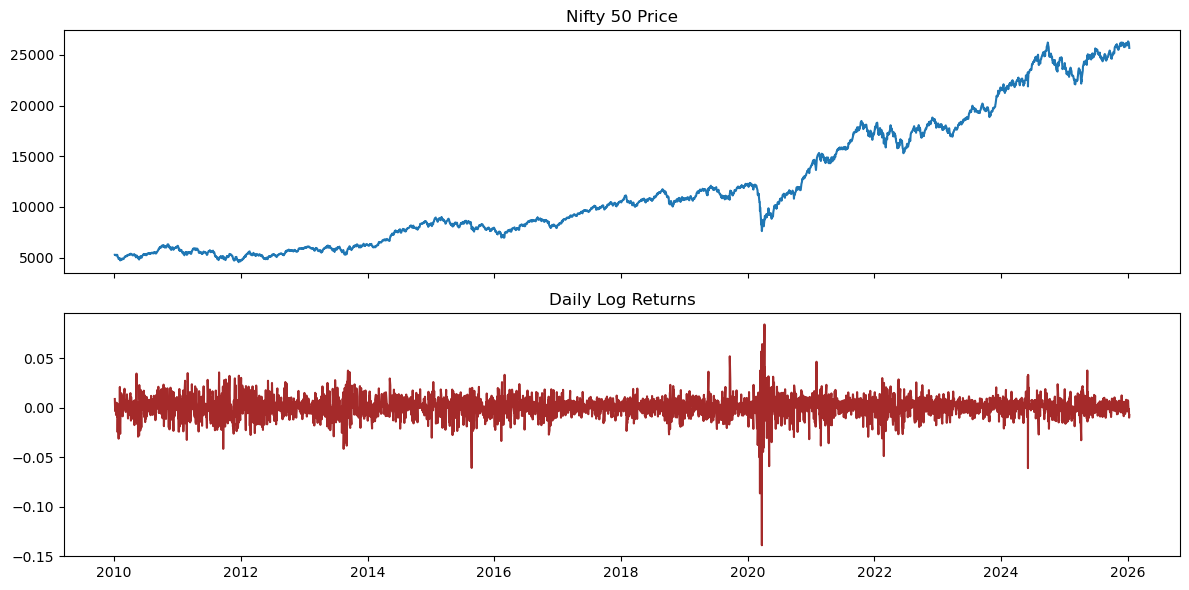

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(n_50.index, n_50['Price'])
ax[0].set_title("Nifty 50 Price")

ax[1].plot(n_50.index, n_50['log_return'], color = 'brown')
ax[1].set_title("Daily Log Returns")

plt.tight_layout()
plt.show()

## 6. Realized Volatility

Realized volatility measures how much the market has actually moved
over a recent window of time.

We compute it using rolling standard deviation of daily log returns.



In [9]:
# Number of trading days in the rolling window
rv_window = 20

# Compute realized volatility (annualized)
n_50['realized_vol'] = (
    n_50['log_return']
    .rolling(rv_window)
    .std()
    * np.sqrt(252)
)

# Drop rows where volatility cannot be computed
n_50 = n_50.dropna()

# .rolling(20) → look back 20 days
# .std() → measure dispersion of returns
# * sqrt(252) → convert daily volatility to annualized volatility


## Sanity check

In [10]:
n_50['realized_vol'].describe()

count    3916.000000
mean        0.147735
std         0.074767
min         0.050175
25%         0.102941
50%         0.133559
75%         0.172379
max         0.904851
Name: realized_vol, dtype: float64

## Visual Validation

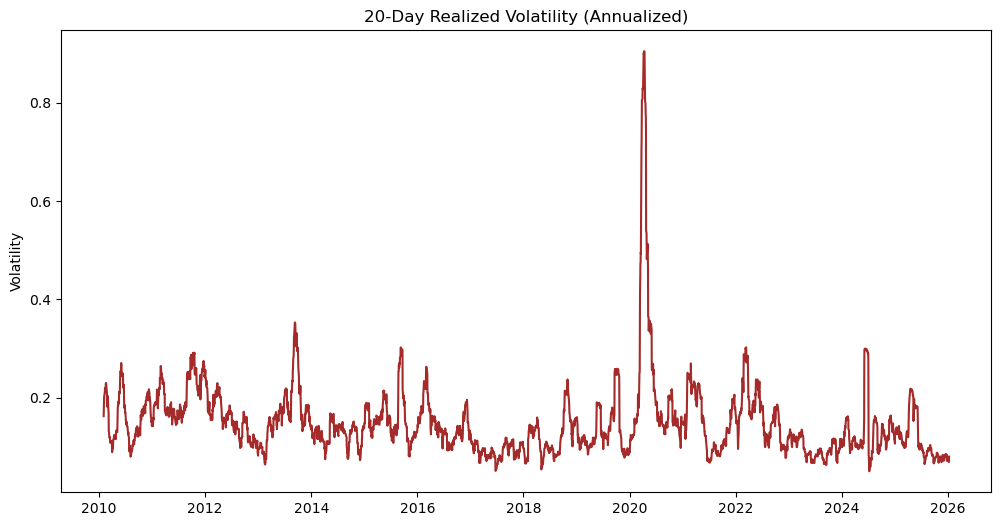

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(n_50.index, n_50['realized_vol'], color = 'brown')
plt.title("20-Day Realized Volatility (Annualized)")
plt.ylabel("Volatility")
plt.show()

## Interpretation of the above plot

You should notice:
* Volatility clusters
* Calm periods followed by violent spikes
* Risk is not constant over time

## 7. Volatility Forecasting

We now forecast future volatility using 3 models
1. EWMA model
2. GARCH(1,1) with zero mean model
3. GARCH(1,1) with constant mean model

This forecast represents the market's expected risk level.

## 1. EWMA model

In [12]:
# EWMA decay factor (RiskMetrics standard)
lambda_ = 0.94
# Slow decay, stable forecast

# Initialize variance column
n_50['ewma_var'] = np.nan

# Set first value using squared return
n_50.iloc[0, n_50.columns.get_loc('ewma_var')] = n_50['log_return'].iloc[0]**2

# Recursive EWMA computation
for i in range(1, len(n_50)):
    n_50.iloc[i, n_50.columns.get_loc('ewma_var')] = (
        lambda_ * n_50.iloc[i - 1]['ewma_var'] +
        (1 - lambda_) * n_50.iloc[i - 1]['log_return']**2
    )

# Convert variance to annualized volatility
n_50['forecast_vol_ewma'] = np.sqrt(n_50['ewma_var'] * 252)
# We square returns → Volatility measures magnitude, not direction
# Recursive loop → Each day’s risk depends on yesterday’s risk + shock
#sqrt(252) → Annualize volatility


Sanity Check

In [13]:
n_50[['realized_vol', 'forecast_vol_ewma']].describe() # EWMA

Price,realized_vol,forecast_vol_ewma
Ticker,,
count,3916.000000,3916.000000
mean,0.147735,0.151180
std,0.074767,0.069177
min,0.050175,0.068316
25%,0.102941,0.110235
50%,0.133559,0.137815
75%,0.172379,0.174542
max,0.904851,0.773932


## 2. GARCH(1,1) with zero mean model

In [ ]:
window = 500
vol_forecast = []

for t in range(window, len(n_50)):
    train = n_50['log_return'].iloc[t-window:t]
    
    model = arch_model(train, p=1, q=1, mean='Zero')
    fit = model.fit(disp='off')
    
    fcast = fit.forecast(horizon=1)
    var = fcast.variance.iloc[-1, 0]
    
    vol_forecast.append(np.sqrt(var * 252))

n_50 = n_50.iloc[window:]
n_50['forecast_vol_garch_1_1_mean_zero'] = vol_forecast

Sanity check

In [15]:
n_50[['realized_vol', 'forecast_vol_garch_1_1_mean_zero']].describe() # GARCH (1,1), mean = 0

Price,realized_vol,forecast_vol_garch_1_1_mean_zero
Ticker,,
count,3416.000000,3416.000000
mean,0.142544,0.149252
std,0.076485,0.067652
min,0.050175,0.075694
25%,0.099315,0.115044
50%,0.127726,0.138712
75%,0.161095,0.163237
max,0.904851,1.185557


## 3. GARCH(1,1) with constant model

In [ ]:
window = 500
vol_forecast = []

for t in range(window, len(n_50)):
    train = n_50['log_return'].iloc[t-window:t]
    
    model = arch_model(train, p=1, q=1, mean='constant')
    fit = model.fit(disp='off')
    
    fcast = fit.forecast(horizon=1)
    var = fcast.variance.iloc[-1, 0]
    
    vol_forecast.append(np.sqrt(var * 252))

n_50 = n_50.iloc[window:]
n_50['forecast_vol_garch_1_1_mean_constant'] = vol_forecast

Sanity check

In [17]:
n_50[['realized_vol', 'forecast_vol_garch_1_1_mean_constant']].describe() # GARCH (1,1), mean = constant

Price,realized_vol,forecast_vol_garch_1_1_mean_constant
Ticker,,
count,2916.000000,2916.000000
mean,0.139807,0.145328
std,0.079808,0.071308
min,0.050175,0.081709
25%,0.096894,0.111671
50%,0.122975,0.133018
75%,0.156842,0.154278
max,0.904851,1.191436


Visual Comparison

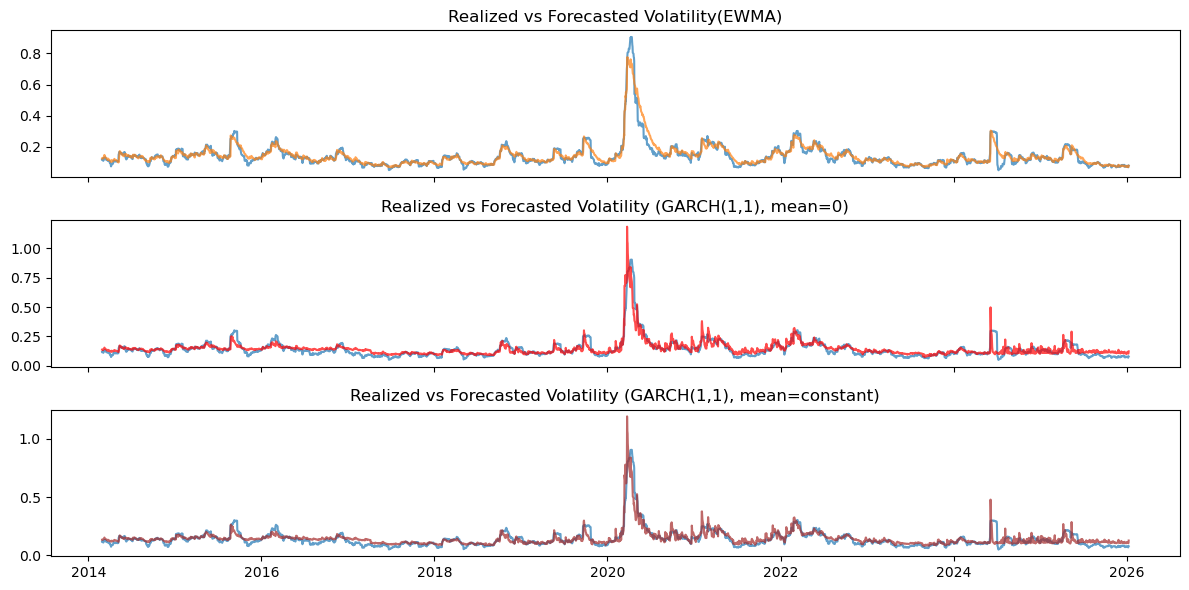

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

ax[0].plot(n_50.index, n_50['realized_vol'], label='Realized Volatility', alpha=0.7)
ax[0].plot(n_50.index, n_50['forecast_vol_ewma'], label='Forecasted Volatility (EWMA)', alpha=0.7)
ax[0].set_title("Realized vs Forecasted Volatility(EWMA)")

ax[1].plot(n_50.index, n_50['realized_vol'], label='Realized Volatility', alpha=0.7)
ax[1].plot(n_50.index, n_50['forecast_vol_garch_1_1_mean_zero'], label='Forecasted Volatility (GARCH(1,1), mean=0)', alpha=0.7, color = 'red')
ax[1].set_title("Realized vs Forecasted Volatility (GARCH(1,1), mean=0)")

ax[2].plot(n_50.index, n_50['realized_vol'], label='Realized Volatility', alpha=0.7)
ax[2].plot(n_50.index, n_50['forecast_vol_garch_1_1_mean_constant'], label='Forecasted Volatility (GARCH(1,1), mean=constant)', alpha=0.7, color = 'brown')
ax[2].set_title("Realized vs Forecasted Volatility (GARCH(1,1), mean=constant)")

plt.tight_layout()
plt.show()

## 8. Volatility Forecast Error

We compute the difference between realized volatility and forecasted volatility.
This error measures how wrong the market's volatility expectation was.


In [19]:
# Volatility forecast error
n_50['vol_error_ewma'] = n_50['realized_vol'] - n_50['forecast_vol_ewma']
n_50['vol_error_garch_1_1_mean_zero'] = n_50['realized_vol'] - n_50['forecast_vol_garch_1_1_mean_zero']
n_50['vol_error_garch_1_1_mean_constant'] = n_50['realized_vol'] - n_50['forecast_vol_garch_1_1_mean_constant']
# n_50['vol_error'].describe()

In [20]:
n_50

Price,Price,log_return,realized_vol,ewma_var,forecast_vol_ewma,forecast_vol_garch_1_1_mean_zero,forecast_vol_garch_1_1_mean_constant,vol_error_ewma,vol_error_garch_1_1_mean_zero,vol_error_garch_1_1_mean_constant
Ticker,^NSEI,,,,,,,,,
Date,,,,,,,,,,
2014-02-28,6276.950195,0.006096,0.117920,0.000063,0.125863,0.137310,0.134763,-0.007943,-0.019390,-0.016843
2014-03-03,6221.450195,-0.008881,0.119243,0.000061,0.124310,0.133828,0.135598,-0.005067,-0.014585,-0.016355
2014-03-04,6297.950195,0.012221,0.125468,0.000062,0.125373,0.137122,0.136845,0.000095,-0.011654,-0.011377
2014-03-05,6328.649902,0.004863,0.110232,0.000068,0.130512,0.140967,0.140395,-0.020280,-0.030735,-0.030162
2014-03-06,6401.149902,0.011391,0.113894,0.000065,0.127941,0.139015,0.138307,-0.014048,-0.025121,-0.024413
...,...,...,...,...,...,...,...,...,...,...
2026-01-05,26250.300781,-0.002976,0.077456,0.000023,0.075430,0.115246,0.112811,0.002026,-0.037790,-0.035354
2026-01-06,26178.699219,-0.002731,0.071136,0.000022,0.074043,0.110005,0.109683,-0.002907,-0.038869,-0.038547


## 9. Z-Score of Forecast Error

In [21]:
# Rolling window for normalization
z_window = 60

n_50['vol_error_z_ewma'] = (
    n_50['vol_error_ewma']
    .rolling(z_window)
    .apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(), raw=False)
)
n_50['vol_error_z_garch_1_1_mean_zero'] = (
    n_50['vol_error_garch_1_1_mean_zero']
    .rolling(z_window)
    .apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(), raw=False)
)
n_50['vol_error_z_garch_1_1_mean_constant'] = (
    n_50['vol_error_garch_1_1_mean_constant']
    .rolling(z_window)
    .apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(), raw=False)
)

n_50 = n_50.dropna()

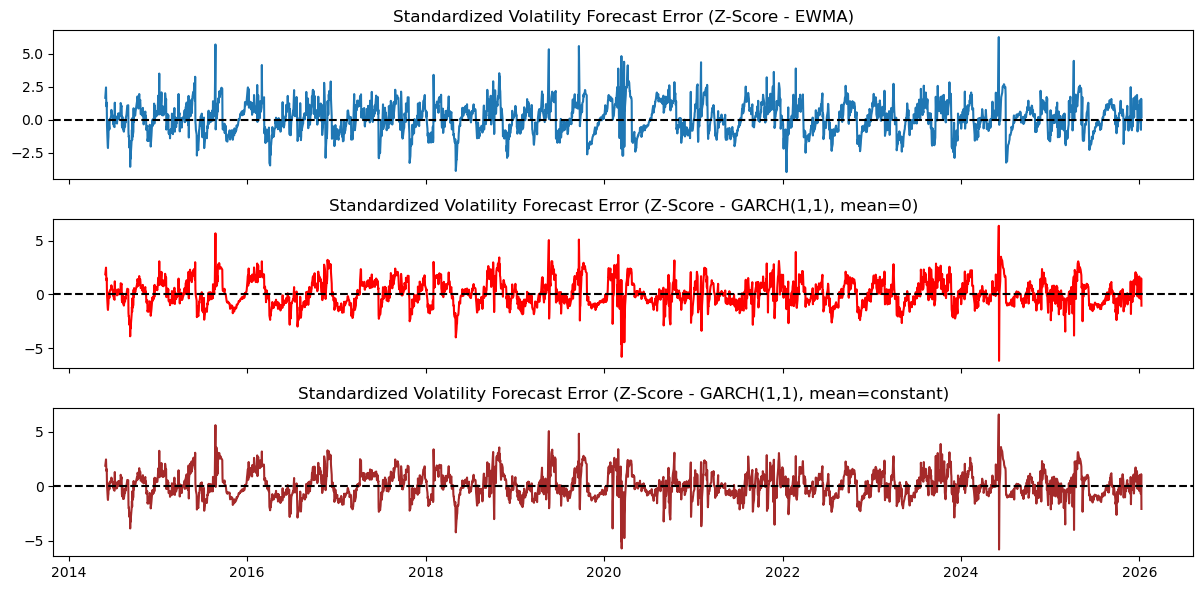

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

ax[0].plot(n_50.index, n_50['vol_error_z_ewma'])
ax[0].axhline(0, color='black', linestyle='--')
ax[0].set_title("Standardized Volatility Forecast Error (Z-Score - EWMA)")

ax[1].plot(n_50.index, n_50['vol_error_z_garch_1_1_mean_zero'], color = 'red')
ax[1].axhline(0, color='black', linestyle='--')
ax[1].set_title("Standardized Volatility Forecast Error (Z-Score - GARCH(1,1), mean=0)")

ax[2].plot(n_50.index, n_50['vol_error_z_garch_1_1_mean_constant'], color = 'brown')
ax[2].axhline(0, color='black', linestyle='--')
ax[2].set_title("Standardized Volatility Forecast Error (Z-Score - GARCH(1,1), mean=constant)")

plt.tight_layout()
plt.show()

Exposure logic

In [23]:
def exposure_rule(z):
    if z < -1:
        return 1.3    # take more risk
    elif z > 1:
        return 0.4    # cut risk
    else:
        return 1.0    # neutral

n_50['signal_exposure_ewma'] = n_50['vol_error_z_ewma'].apply(exposure_rule)
n_50['signal_exposure_garch_1_1_mean_zero'] = n_50['vol_error_z_garch_1_1_mean_zero'].apply(exposure_rule)
n_50['signal_exposure_garch_1_1_mean_constant'] = n_50['vol_error_z_garch_1_1_mean_constant'].apply(exposure_rule)

C:\Users\david\AppData\Local\Temp\ipykernel_20204\1660417031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['signal_exposure_ewma'] = n_50['vol_error_z_ewma'].apply(exposure_rule)
C:\Users\david\AppData\Local\Temp\ipykernel_20204\1660417031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['signal_exposure_garch_1_1_mean_zero'] = n_50['vol_error_z_garch_1_1_mean_zero'].apply(exposure_rule)
C:\Users\david\AppData\Local\Temp\ipykernel_20204\1660417031.py:11: SettingWithCopyWarning: 
A value 

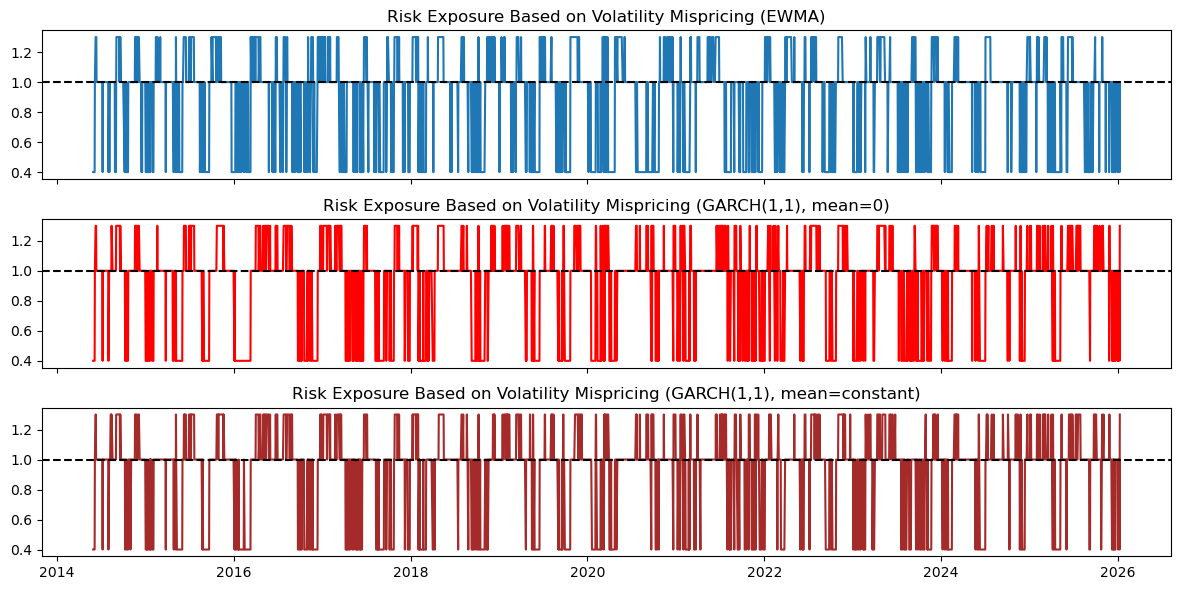

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

ax[0].plot(n_50.index, n_50['signal_exposure_ewma'])
ax[0].axhline(1, color='black', linestyle='--')
ax[0].set_title("Risk Exposure Based on Volatility Mispricing (EWMA)")

ax[1].plot(n_50.index, n_50['signal_exposure_garch_1_1_mean_zero'], color = 'red')
ax[1].axhline(1, color='black', linestyle='--')
ax[1].set_title("Risk Exposure Based on Volatility Mispricing (GARCH(1,1), mean=0)")

ax[2].plot(n_50.index, n_50['signal_exposure_garch_1_1_mean_constant'], color = 'brown')
ax[2].axhline(1, color='black', linestyle='--')
ax[2].set_title("Risk Exposure Based on Volatility Mispricing (GARCH(1,1), mean=constant)")

plt.tight_layout()
plt.show()

## 10. Volatility targeting

We scale position size so that portfolio risk remains stable
across different volatility regimes.

In [ ]:
# Target annualized portfolio volatility
target_vol = 0.10

# Volatility-based position scaling
n_50['vol_target_scaler_ewma'] = target_vol / n_50['forecast_vol_ewma']
n_50['vol_target_scaler_garch_1_1_mean_zero'] = target_vol / n_50['forecast_vol_garch_1_1_mean_zero']
n_50['vol_target_scaler_garch_1_1_mean_constant'] = target_vol / n_50['forecast_vol_garch_1_1_mean_constant']

#If forecast volatility is high, scaler < 1 → reduce position
#If forecast volatility is low, scaler > 1 → increase position


C:\Users\david\AppData\Local\Temp\ipykernel_20204\1255655576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['vol_target_scaler_ewma'] = target_vol / n_50['forecast_vol_ewma']
C:\Users\david\AppData\Local\Temp\ipykernel_20204\1255655576.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['vol_target_scaler_garch_1_1_mean_zero'] = target_vol / n_50['forecast_vol_garch_1_1_mean_zero']
C:\Users\david\AppData\Local\Temp\ipykernel_20204\1255655576.py:7: SettingWithCopyWarning: 
A value is trying to

To Cap the Exposure (Risk Safety)

In [ ]:
# To prevent unlimited scaling, we clip to max of 1.5
# Prevents over-exposure in ultra-low-vol regimes
# Reflects real trading constraints
n_50['vol_target_scaler_ewma']= n_50['vol_target_scaler_ewma'].clip(upper=1.5)
n_50['vol_target_scaler_garch_1_1_mean_zero']= n_50['vol_target_scaler_garch_1_1_mean_zero'].clip(upper=1.5)
n_50['vol_target_scaler_garch_1_1_mean_constant']= n_50['vol_target_scaler_garch_1_1_mean_constant'].clip(upper=1.5)


C:\Users\david\AppData\Local\Temp\ipykernel_20204\1958549354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['vol_target_scaler_ewma']= n_50['vol_target_scaler_ewma'].clip(upper=1.5)
C:\Users\david\AppData\Local\Temp\ipykernel_20204\1958549354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['vol_target_scaler_garch_1_1_mean_zero']= n_50['vol_target_scaler_garch_1_1_mean_zero'].clip(upper=1.5)
C:\Users\david\AppData\Local\Temp\ipykernel_20204\1958549354.py:6: SettingWithCopyWarning: 
A valu

## Combine Signal + Risk Control

In [ ]:
n_50['final_exposure_ewma'] = n_50['signal_exposure_ewma'] * n_50['vol_target_scaler_ewma']
n_50['final_exposure_garch_1_1_mean_zero'] = n_50['signal_exposure_garch_1_1_mean_zero'] * n_50['vol_target_scaler_garch_1_1_mean_zero']
n_50['final_exposure_garch_1_1_mean_constant'] = n_50['signal_exposure_garch_1_1_mean_constant'] * n_50['vol_target_scaler_garch_1_1_mean_constant']

C:\Users\david\AppData\Local\Temp\ipykernel_20204\2011921546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['final_exposure_ewma'] = n_50['signal_exposure_ewma'] * n_50['vol_target_scaler_ewma']
C:\Users\david\AppData\Local\Temp\ipykernel_20204\2011921546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['final_exposure_garch_1_1_mean_zero'] = n_50['signal_exposure_garch_1_1_mean_zero'] * n_50['vol_target_scaler_garch_1_1_mean_zero']
C:\Users\david\AppData\Local\Temp\ipykernel_20204\2011921

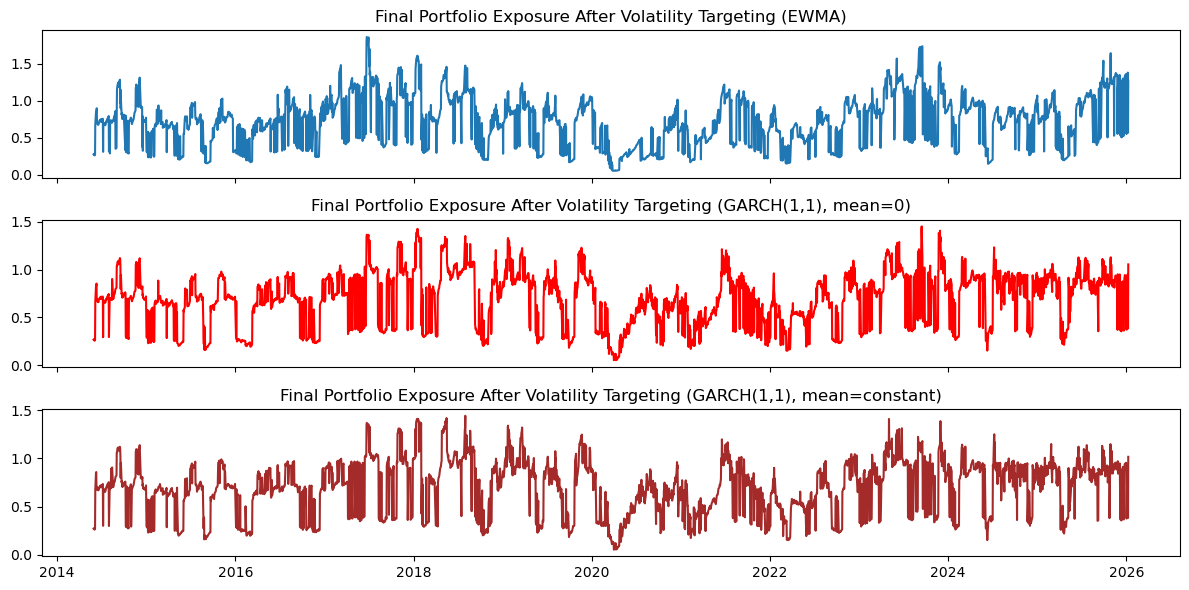

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

ax[0].plot(n_50.index, n_50['final_exposure_ewma'])
ax[0].set_title("Final Portfolio Exposure After Volatility Targeting (EWMA)")

ax[1].plot(n_50.index, n_50['final_exposure_garch_1_1_mean_zero'], color = 'red')
ax[1].set_title("Final Portfolio Exposure After Volatility Targeting (GARCH(1,1), mean=0)")

ax[2].plot(n_50.index, n_50['final_exposure_garch_1_1_mean_constant'], color = 'brown')
ax[2].set_title("Final Portfolio Exposure After Volatility Targeting (GARCH(1,1), mean=constant)")

plt.tight_layout()
plt.show()

Interpretation:
* Exposure shrinks during crises
* Exposure grows during calm periods
* No extreme spikes

# 11. Strategy return

In [31]:
# Strategy returns (lag exposure by one day)
n_50['strategy_return_ewma'] = n_50['final_exposure_ewma'].shift(1) * n_50['log_return']
n_50['strategy_return_garch_1_1_mean_zero'] = n_50['final_exposure_garch_1_1_mean_zero'].shift(1) * n_50['log_return']
n_50['strategy_return_garch_1_1_mean_constant'] = n_50['final_exposure_garch_1_1_mean_constant'].shift(1) * n_50['log_return']

# Buy & hold benchmark
n_50['bh_return'] = n_50['log_return']

# Drop initial NaN from shifting
n_50 = n_50.dropna()

# .shift(1) → today’s position decided yesterday
# Multiplying by returns → PnL simulation
# Buy & hold → baseline comparison

C:\Users\david\AppData\Local\Temp\ipykernel_20204\2252350548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['strategy_return_ewma'] = n_50['final_exposure_ewma'].shift(1) * n_50['log_return']
C:\Users\david\AppData\Local\Temp\ipykernel_20204\2252350548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_50['strategy_return_garch_1_1_mean_zero'] = n_50['final_exposure_garch_1_1_mean_zero'].shift(1) * n_50['log_return']
C:\Users\david\AppData\Local\Temp\ipykernel_20204\2252350548.py:4: SettingWith

Equity Curve construction

In [32]:
n_50['strategy_equity_ewma'] = np.exp(n_50['strategy_return_ewma'].cumsum())
n_50['strategy_equity_garch_1_1_mean_zero'] = np.exp(n_50['strategy_return_garch_1_1_mean_zero'].cumsum())
n_50['strategy_equity_garch_1_1_mean_constant'] = np.exp(n_50['strategy_return_garch_1_1_mean_constant'].cumsum())
n_50['bh_equity'] = np.exp(n_50['bh_return'].cumsum())

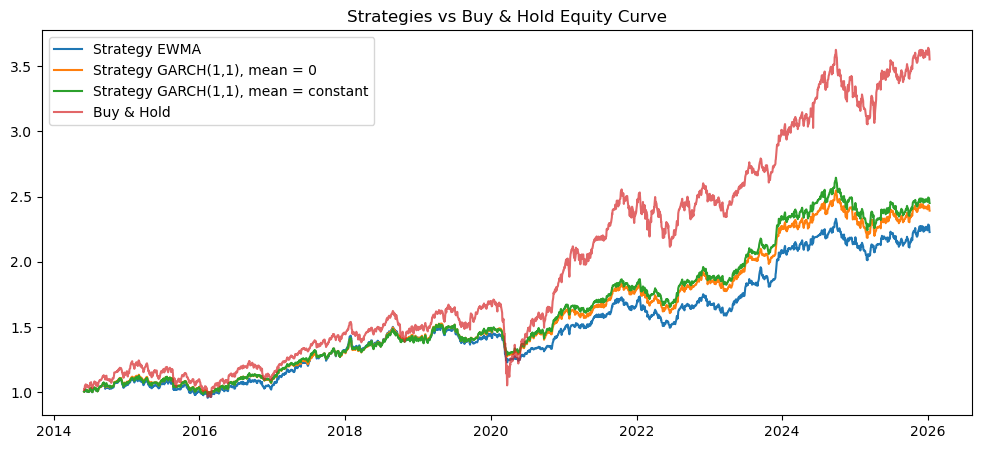

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(n_50.index, n_50['strategy_equity_ewma'], label='Strategy EWMA')
plt.plot(n_50.index, n_50['strategy_equity_garch_1_1_mean_zero'], label='Strategy GARCH(1,1), mean = 0')
plt.plot(n_50.index, n_50['strategy_equity_garch_1_1_mean_constant'], label='Strategy GARCH(1,1), mean = constant')
plt.plot(n_50.index, n_50['bh_equity'], label='Buy & Hold', alpha=0.7)
plt.legend()
plt.title("Strategies vs Buy & Hold Equity Curve")
plt.show()

Metric Functions

In [44]:
def max_drawdown(equity):
    peak = equity.cummax()
    return round(((equity - peak) / peak).min() * 100, 2)

In [50]:
results = {
    "Max Drawdown - Buy & Hold": f"{max_drawdown(n_50['bh_equity'])}%",
    "Max Drawdown - EWMA": f"{max_drawdown(n_50['strategy_equity_ewma'])}%",
    "Max Drawdown - GARCH(1,1), mean = 0": f"{max_drawdown(n_50['strategy_equity_garch_1_1_mean_zero'])}%",
    "Max Drawdown - GARCH(1,1), mean = constant": f"{max_drawdown(n_50['strategy_equity_garch_1_1_mean_constant'])}%"
}

results

{'Max Drawdown - Buy & Hold': '-38.44%',
 'Max Drawdown - EWMA': '-18.3%',
 'Max Drawdown - GARCH(1,1), mean = 0': '-16.57%',
 'Max Drawdown - GARCH(1,1), mean = constant': '-15.7%'}

Crisis Performance Check

In [46]:
crisis_period = n_50.loc['2020':'2022']

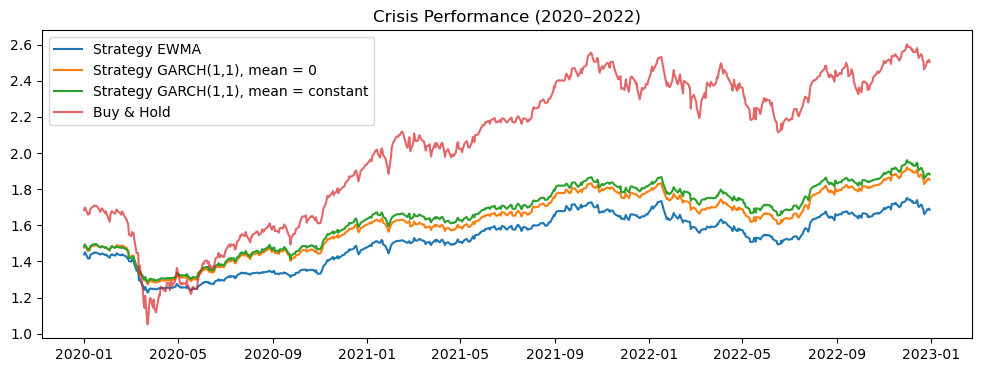

In [48]:
plt.figure(figsize=(12, 4))
plt.plot(crisis_period.index, crisis_period['strategy_equity_ewma'], label='Strategy EWMA')
plt.plot(crisis_period.index, crisis_period['strategy_equity_garch_1_1_mean_zero'], label='Strategy GARCH(1,1), mean = 0')
plt.plot(crisis_period.index, crisis_period['strategy_equity_garch_1_1_mean_constant'], label='Strategy GARCH(1,1), mean = constant')
plt.plot(crisis_period.index, crisis_period['bh_equity'], label='Buy & Hold', alpha=0.7)
plt.legend()
plt.title("Crisis Performance (2020–2022)")
plt.show()


What you see:
* Strategy de-risking earlier
* Smaller drawdowns
* Faster recovery